# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import syft as sy
import copy
hook = sy.TorchHook(torch)

In [3]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
# create a couple workers
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
secure_worker_a = sy.VirtualWorker(hook, id="secure_worker_a")
secure_worker_b = sy.VirtualWorker(hook, id="secure_worker_b")

In [5]:
# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets

federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR10('/home/zhaojia-raoxy/data', train=True, download=True,
                   transform=train_transforms)
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.CIFAR10('/home/zhaojia-raoxy/data', train=False, download=True,
                   transform=test_transforms)
    .federate((secure_worker_a, secure_worker_b)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

Files already downloaded and verified


Files already downloaded and verified


# ResNet18

In [6]:
model_name = '/home/zhaojia-raoxy/model/resnet18-5c106cde.pth'

def ResNet_s(args):
    ''':cvar
    返回修改好的模型，和冻结好的参数
    '''
    from torchvision.models import resnet18
    pretrain_model = resnet18(pretrained=False)
    pretrain_model.fc = nn.Linear(pretrain_model.fc.in_features, 100)  # 将全连接层改为自己想要的分类输出
    pretrained_dict = torch.load(model_name)

    pretrained_dict.pop('fc.weight')
    pretrained_dict.pop('fc.bias')

    model_dict = pretrain_model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    model_dict.update(pretrained_dict)  # 模型参数列表进行参数更新，加载参数
    pretrain_model.load_state_dict(model_dict)  # 将满足条件的参数的 requires_grad 属性设置为False

#     for name, value in pretrain_model.named_parameters():
#         if (name != 'fc.weight') and (name != 'fc.bias'):
#             value.requires_grad = False
    params_conv = filter(lambda p: p.requires_grad, pretrain_model.parameters())  # 要更新的参数在parms_conv当中
    return pretrain_model, params_conv

model, params_conv = ResNet_s(model_name)
model = model.to(device)
optimizer = optim.SGD(params_conv, lr=0.03) # TODO momentum is not supported at the moment

# 训练

In [7]:
criterion = nn.CrossEntropyLoss().to(device)

In [8]:
loss_test=[]
acc_test=[]

def test(model, device, federated_test_loader, batch_size): 
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
            model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            n+=target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
            model.get()
            test_loss += loss.get() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().get()

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/ n)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [9]:
loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        n+=target.shape[0]
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
        correct += pred.eq(target.view_as(pred)).sum().get()
        train_loss+=loss.get()
#         loss = F.cross_entropy(output, target.long())
#         loss = F.nll_loss(output, target)
        model.get() # <-- NEW: get the model back
    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)
    
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
    100. * correct /n))

In [10]:
for epoch in range(500):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 1.8667, Accuracy: 17771/50000 (36%)
Test set: Average loss: 1.3347, Accuracy: 5131/10000 (51%)
Train set: Average loss: 1.1462, Accuracy: 30257/50000 (61%)
Test set: Average loss: 0.9951, Accuracy: 6567/10000 (66%)
Train set: Average loss: 0.8686, Accuracy: 35088/50000 (70%)
Test set: Average loss: 0.8285, Accuracy: 7216/10000 (72%)
Train set: Average loss: 0.7377, Accuracy: 37344/50000 (75%)
Test set: Average loss: 0.7302, Accuracy: 7512/10000 (75%)
Train set: Average loss: 0.6361, Accuracy: 39043/50000 (78%)
Test set: Average loss: 0.7006, Accuracy: 7628/10000 (76%)
Train set: Average loss: 0.5655, Accuracy: 40254/50000 (81%)
Test set: Average loss: 0.6386, Accuracy: 7803/10000 (78%)
Train set: Average loss: 0.5098, Accuracy: 41178/50000 (82%)
Test set: Average loss: 0.6679, Accuracy: 7793/10000 (78%)
Train set: Average loss: 0.4449, Accuracy: 42360/50000 (85%)
Test set: Average loss: 0.6108, Accuracy: 7965/10000 (80%)
Train set: Average loss: 0.3997, Accurac

# 结果保存

In [11]:
save_name='ResNet18'

In [12]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/ResNet18.pt


In [13]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/ResNet18.h5


# 分析

In [14]:
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.use('nbAgg')
mpl.style.use('seaborn-darkgrid')
import numpy as np

In [ ]:
loss_test =np.array([tensor.item() for tensor in loss_test], dtype=np.float32)
loss_train=np.array([tensor.item() for tensor in loss_train], dtype=np.float32)
acc_train=np.array([tensor.item() for tensor in acc_train], dtype=np.float32)
acc_test=np.array([tensor.item() for tensor in acc_test], dtype=np.float32)

In [16]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("/home/zhaojia-raoxy/files/{}".format(save_name),index=False)

<IPython.core.display.Javascript object>


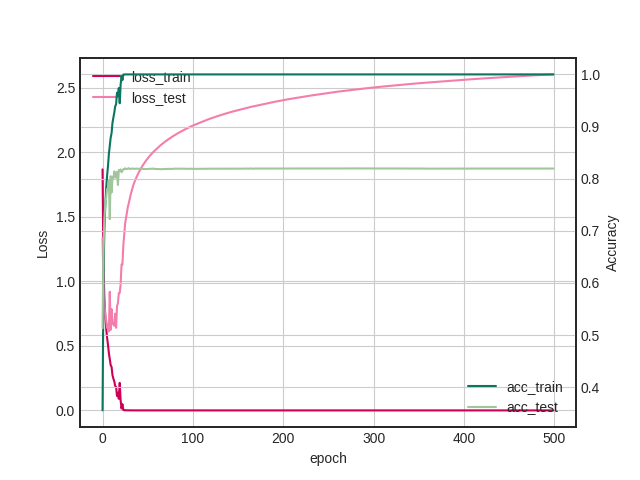

In [17]:
mpl.style.use('seaborn-white')
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)

# 显示图形
plt.show()